In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Parallel processing comparation between OpenMP, CUDA and MPI
We start by loading the benchmark results into a data frame and aggregating multiple runs by geometric mean

In [2]:
# Declare index structure
col = ("test250", "test500", "test750", "test1", "test1.5", "test2", "test2.5", "test3", "test3.5", "test4", "test4.5")
scol = [str(i) for i in range(1,8)]
row =  ("seq", "omp", "cuda", "mpi")
srow = ("cycles", "real_time_nsec", "PAPI_TOT_INS", "PAPI_TOT_CYC")

mcol = pd.MultiIndex.from_product([col,scol])
mrow = pd.MultiIndex.from_product([row,srow])

# Recollect data
df = pd.DataFrame(np.loadtxt("test2.csv", delimiter=','), index=mrow, columns=mcol)

# Compute geometric mean
gmean = pd.DataFrame(np.full((mrow.size, len(col)), np.nan), index=mrow, columns=col)
for c in col:
    gmean[c] = df[c].aggregate(lambda ite: ite.prod()**(1.0/len(ite)), axis="columns")

# Display dataframe
gmean


test250       test500       test750         test1  \
seq  cycles          1.673387e+08  1.400288e+09  5.168005e+09  1.433770e+10   
     real_time_nsec  5.232133e+07  4.378439e+08  1.615942e+09  4.483145e+09   
     PAPI_TOT_INS    4.075696e+08  3.255260e+09  1.098058e+10  2.602102e+10   
     PAPI_TOT_CYC    1.738307e+08  1.451016e+09  5.384591e+09  1.499463e+10   
omp  cycles          4.444127e+07  3.716906e+08  1.349542e+09  3.549884e+09   
     real_time_nsec  1.389178e+07  1.162130e+08  4.219572e+08  1.109934e+09   
     PAPI_TOT_INS    1.061682e+08  8.466837e+08  2.851691e+09  6.756734e+09   
     PAPI_TOT_CYC    4.347740e+07  3.532998e+08  1.321587e+09  3.422319e+09   
cuda cycles          6.113518e+08  6.550990e+08  1.551534e+09  3.288008e+09   
     real_time_nsec  1.911505e+08  2.048298e+08  4.851213e+08  1.028072e+09   
     PAPI_TOT_INS    1.596837e+08  1.014361e+09  2.947688e+09  6.494564e+09   
     PAPI_TOT_CYC    8.616050e+07  5.132214e+08  1.453668e+09  3.259434e+09   
mpi  cycles          3.651468e+08  9.553674e+08  2.449380e+09  3.257361e+09   
     real_time_nsec  1.141717e+08  2.987185e+08  7.658608e+08  1.018497e+09   
     PAPI_TOT_INS    1.483978e+08  4.798835e+08  1.301978e+09  2.710258e+09   
     PAPI_TOT_CYC    9.935791e+07  3.087363e+08  1.137216e+09  1.662381e+09   

                          test1.5         test2       test2.5         test3  \
seq  cycles          6.279546e+10  1.261305e+11  2.900260e+11  4.165637e+11   
     real_time_nsec  1.963483e+10  3.943876e+10  9.068526e+10  1.302521e+11   
     PAPI_TOT_INS    8.779729e+10  2.080841e+11  4.063814e+11  7.021892e+11   
     PAPI_TOT_CYC    6.261429e+10  1.321494e+11  2.894857e+11  4.365239e+11   
omp  cycles          1.616566e+10  3.267203e+10  7.747911e+10  1.020482e+11   
     real_time_nsec  5.054658e+09  1.021551e+10  2.422608e+10  3.190734e+10   
     PAPI_TOT_INS    2.279524e+10  5.402473e+10  1.055051e+11  1.823011e+11   
     PAPI_TOT_CYC    1.470458e+10  3.189985e+10  7.112760e+10  9.965204e+10   
cuda cycles          1.126163e+10  2.488206e+10  4.859853e+10  8.317345e+10   
     real_time_nsec  3.521273e+09  7.779971e+09  1.519575e+10  2.600620e+10   
     PAPI_TOT_INS    2.178860e+10  5.309459e+10  1.012159e+11  1.803901e+11   
     PAPI_TOT_CYC    1.077591e+10  2.588560e+10  4.920768e+10  8.707335e+10   
mpi  cycles          1.208917e+10  2.599177e+10  5.636785e+10  9.460761e+10   
     real_time_nsec  3.780030e+09  8.126999e+09  1.762507e+10  2.958155e+10   
     PAPI_TOT_INS    8.933570e+09  2.114467e+10  4.136313e+10  7.333039e+10   
     PAPI_TOT_CYC    6.551384e+09  1.403380e+10  3.067981e+10  4.393720e+10   

                          test3.5         test4       test4.5  
seq  cycles          9.056659e+11  1.244813e+12  2.003902e+12  
     real_time_nsec  2.831838e+11  3.892223e+11  6.265785e+11  
     PAPI_TOT_INS    1.115008e+12  1.664336e+12  2.369676e+12  
     PAPI_TOT_CYC    9.085283e+11  1.303387e+12  2.018170e+12  
omp  cycles          2.853180e+11  3.579617e+11  6.151306e+11  
     real_time_nsec  8.921292e+10  1.119246e+11  1.923386e+11  
     PAPI_TOT_INS    2.894765e+11  4.320903e+11  6.152067e+11  
     PAPI_TOT_CYC    2.592454e+11  3.485590e+11  5.558442e+11  
cuda cycles          6.103177e+10  7.835403e+10  4.251366e+10  
     real_time_nsec  1.908331e+10  2.449922e+10  1.329301e+10  
     PAPI_TOT_INS    1.130997e+11  1.164258e+11  4.200807e+10  
     PAPI_TOT_CYC    5.869076e+10  7.215168e+10  3.382153e+10  
mpi  cycles          2.067907e+11  3.563623e+11  5.396456e+11  
     real_time_nsec  6.465925e+10  1.114263e+11  1.687362e+11  
     PAPI_TOT_INS    1.190972e+11  1.870063e+11  2.683918e+11  
     PAPI_TOT_CYC    1.006563e+11  1.691029e+11  2.298750e+11

The data is structured by the computation technique used.

## Comparing speed-ups between the different techniques

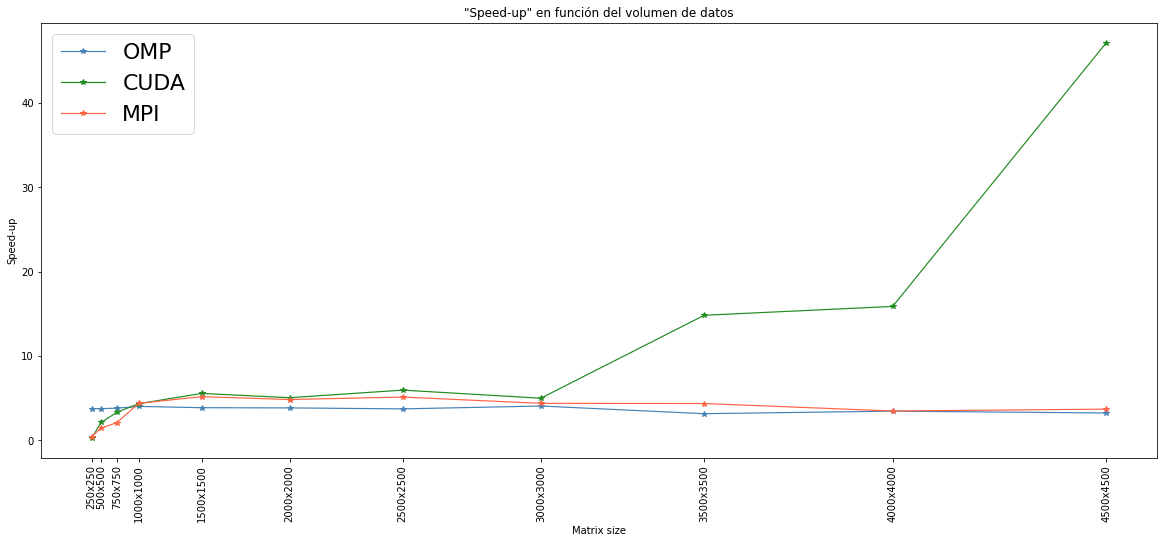

In [76]:
omp_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["omp", "real_time_nsec"])
cuda_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["cuda", "real_time_nsec"])
mpi_sp = gmean.loc["seq","real_time_nsec"].div(gmean.loc["mpi", "real_time_nsec"])

xaxis = np.array([250, 500, 750, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500])**2

fig, ax = plt.subplots()

xlabel = ['250x250', '500x500', '750x750', '1000x1000', '1500x1500', '2000x2000', '2500x2500','3000x3000', '3500x3500','4000x4000', '4500x4500']

ax.plot(xaxis, omp_sp,'*-', label='OMP', color="steelblue", linewidth=edgewidth)
ax.plot(xaxis, cuda_sp, '*-', color="forestgreen", label='CUDA', linewidth=edgewidth)
ax.plot(xaxis, mpi_sp, '*-', color="tomato", label='MPI', linewidth=edgewidth)

ax.set_title("\"Speed-up\" en función del volumen de datos")
ax.set_ylabel("Speed-up")
ax.set_xlabel("Matrix size")
ax.set_xticks(xaxis)
ax.set_xticklabels(xlabel, rotation=90)
ax.legend(fontsize=22)

# Añadir separación realista eje x
# Arreglar esta mierda cabrón

fig.set_size_inches((20, 8))

plt.show()


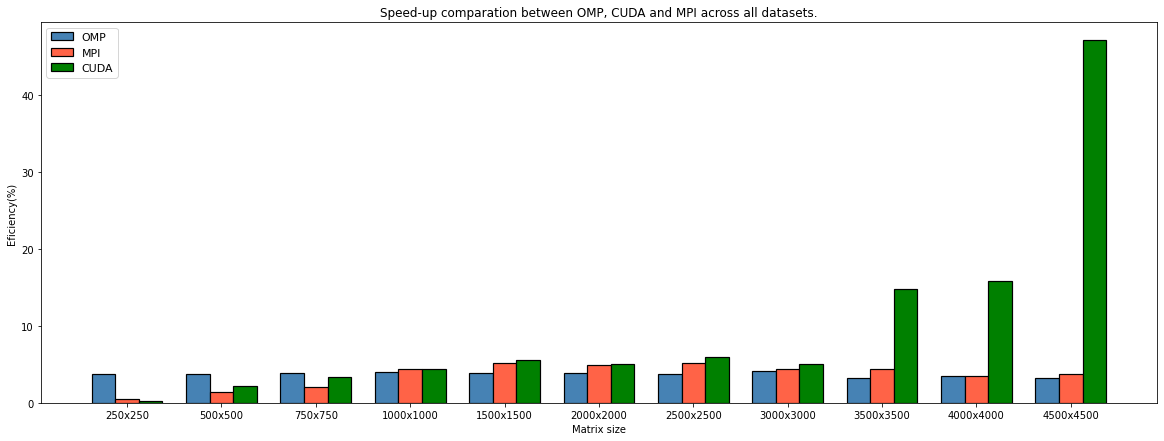

In [81]:
fig, ax = plt.subplots()

xaxis = np.arange(len(xlabel))
width = 0.25
edgewidth = 1.2

ax.bar(xaxis - width, omp_sp, width,label='OMP', color="steelblue", edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis, mpi_sp, width, color="tomato", label='MPI', edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + width, cuda_sp, width, color="green", label='CUDA', edgecolor='black', linewidth=edgewidth)

ax.set_title("Speed-up comparation between OMP, CUDA and MPI across all datasets.")
ax.set_ylabel("Eficiency(%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=11)

fig.set_size_inches((20,7))

plt.show()

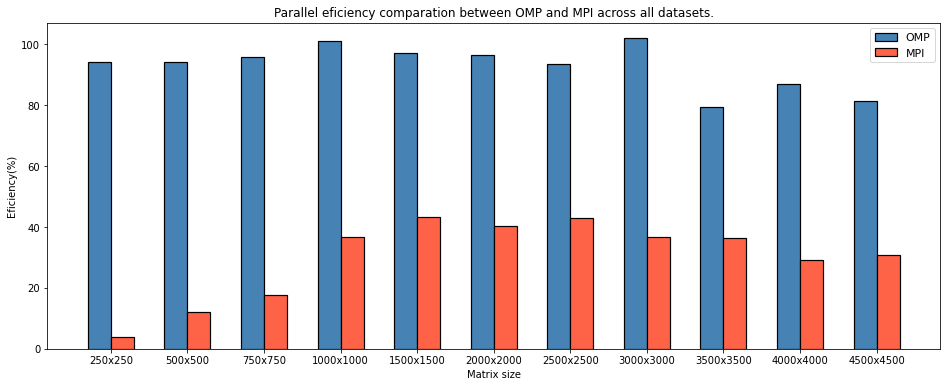

In [62]:
omp_cores = 4
cuda_cores = 1664
mpi_cores = 12

omp_ef = 100*omp_sp/omp_cores
cuda_ef = 100*cuda_sp/cuda_cores
mpi_ef = 100*mpi_sp/mpi_cores

fig, ax = plt.subplots()

xaxis = np.arange(1, len(xlabel)+1)
width = 0.3
edgewidth = 1.2

ax.bar(xaxis - width/2, omp_ef, width,label='OMP', color="steelblue", edgecolor='black', linewidth=edgewidth)
ax.bar(xaxis + width/2, mpi_ef, width, color="tomato", label='MPI', edgecolor='black', linewidth=edgewidth)

ax.set_title("Parallel eficiency comparation between OMP and MPI across all datasets.")
ax.set_ylabel("Eficiency(%)")
ax.set_xlabel("Matrix size")
ax.set_xticklabels(xlabel)
ax.set_xticks(xaxis)
ax.legend(fontsize=11)

fig.set_size_inches((16,6))

plt.show()
